# 1) Setup colab GPU runtime environment

In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-8zdex43d
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-8zdex43d
  Resolved https://github.com/albumentations-team/albumentations to commit 51852f9360e8e7cce8b6c562f6ecaaf7267a3101
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 19.7 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-2.0.0-py3-none-any.whl size=276823 sha256=28b9457864107c913753d98389e5eaa378d6ee86bc9fff99a8944bad24a50c51
  Stored in directory: /tmp/pip-ephem-wheel-cache-k2q5a1en/wheels/d8/87/c6/794399113ca308f93f3af45afd7d85eff07615a89a2b799e91
Successfully built albumentations
  Attempting uninstall: albuc

# 1.1. Download Dataset

In [2]:
!git clone https://github.com/balarcode/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 1004, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 1004 (delta 34), reused 20 (delta 11), pack-reused 953 (from 1)
Receiving objects: 100% (1004/1004), 25.44 MiB | 22.79 MiB/s, done.
Resolving deltas: 100% (100/100), done.


# 1.2. Common Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2 # OpenCV library
import torch # PyTorch library
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/deep-learning/computer_vision/object_localization/data')

# 2) Setup Configuration

In [5]:
CSV_FILE = '/content/deep-learning/computer_vision/object_localization/data/training.csv'
DATA_DIR = '/content/deep-learning/computer_vision/object_localization/data/'

DEVICE = 'cuda' # GPU will be used for execution

EPOCHS = 50
LR = 0.001 # Learning Rate
IMAGE_SIZE = 140 # Height = Width
BATCH_SIZE = 16

MODEL_NAME = 'efficientnet_b0' # resnet34, resnet50, efficientnet_b3, efficientnet_b7, etc.
NUM_COORDINATES = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,training_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,training_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,training_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,training_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,training_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,training_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,training_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,training_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,training_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# 2.1. Plot Images from the Dataset

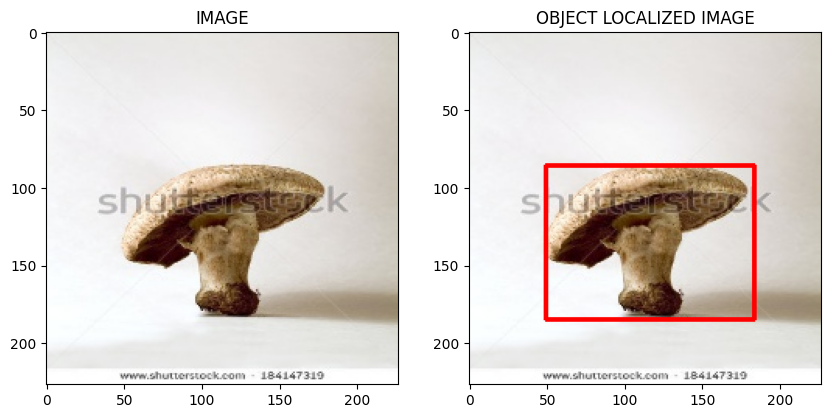

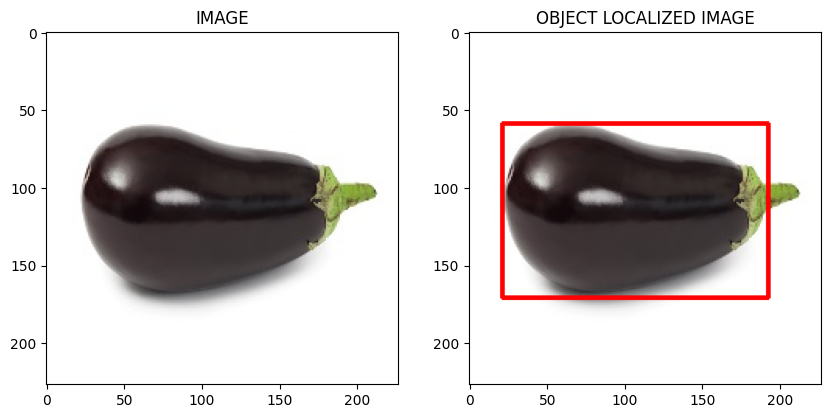

In [7]:
row = df.iloc[2] # Select the row in the data frame
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img = cv2.imread(DATA_DIR + row.img_path) # Select the column
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.set_title('IMAGE')
ax1.imshow(img)
min = (row.xmin, row.ymin) # Coordinates for the ground truth bounding box
max = (row.xmax, row.ymax) # Coordinates for the ground truth bounding box
color = (255, 0, 0) # Red color for the ground truth bounding box
bounding_box_img = cv2.rectangle(img, min, max, color, 2)
ax2.set_title('OBJECT LOCALIZED IMAGE')
ax2.imshow(bounding_box_img)

row = df.iloc[184] # Select the row in the data frame
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img = cv2.imread(DATA_DIR + row.img_path) # Select the column
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax1.set_title('IMAGE')
ax1.imshow(img)
min = (row.xmin, row.ymin) # Coordinates for the ground truth bounding box
max = (row.xmax, row.ymax) # Coordinates for the ground truth bounding box
color = (255, 0, 0) # Red color for the ground truth bounding box
bounding_box_img = cv2.rectangle(img, min, max, color, 2)
ax2.set_title('OBJECT LOCALIZED IMAGE')
ax2.imshow(bounding_box_img)

In [8]:
# Split the dataset into training and validation datasets
training_df, validation_df = train_test_split(df, test_size=0.20, random_state=42)

# 3) Augmentation Functions

In [9]:
# Augmentation brings certain transformations to the image dataset. Image augmentation is a process of creating new training examples from the existing ones in order to
# improve the quality and performance of the deep neural network.
# Albumentations library is used for image augmentation and it can be applied to a variety of datasets for image segmentation, image object detection, image classification, etc.
# For localization task, application of augmentation doesn't bring the same effect to both original and object localized images. This means, depending on the augementation applied,
# the bounding box for the localized object will need to be changed accordingly.
import albumentations as A

In [10]:
training_augs = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

validation_augs = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# 4) Create Custom Dataset

In [11]:
class ObjectLocalizationDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin, ymin, xmax, ymax]] # Nested list
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Input image format = (height, width, channel) = axis(0, 1, 2)
    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels=[None]) # Augment the input image and return a dictionary
      img = data['image']
      bbox = data['bboxes'][0]
    # Convert the image per PyTorch convention to a Tensor
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # Change image format using permute so that format = (channel, height, width) to match to PyTorch convention
    bbox = torch.Tensor(bbox)
    return img, bbox

In [12]:
trainingset = ObjectLocalizationDataset(training_df, training_augs)
validationset = ObjectLocalizationDataset(validation_df, validation_augs)

In [13]:
print(f"Total images in the training set: {len(trainingset)}")
print(f"Total images in the validation set: {len(validationset)}")

Total images in the training set: 148
Total images in the validation set: 38


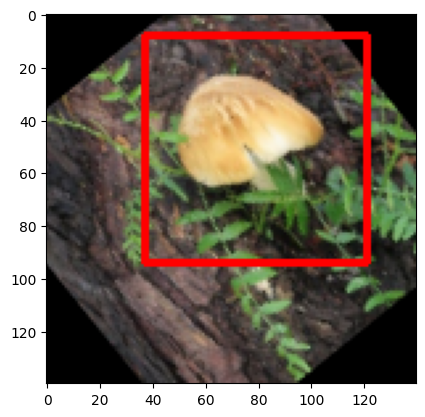

In [14]:
# Plot an image after image augmentation from the training set
img, bbox = trainingset[64]

xmin, ymin, xmax, ymax = bbox

min = (int(xmin), int(ymin))
max = (int(xmax), int(ymax))
color = (255,0,0)

bounding_box_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), min, max, color, 2) # Reorder the axes for the image and change the image data to a numpy array instead of a PyTorch tensor
plt.imshow(bounding_box_img)

# 5) Load Dataset into Batches

In [15]:
trainingloader = torch.utils.data.DataLoader(trainingset, batch_size=BATCH_SIZE, shuffle=True) # At every Epoch, the batches get shuffled if 'shuffle' parameter is set to True
validationloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print("Total number of batches in trainingloader : {}".format(len(trainingloader)))
print("Total number of batches in validationloader : {}".format(len(validationloader)))

Total number of batches in trainingloader : 10
Total number of batches in validationloader : 3


In [17]:
for images, bboxes in trainingloader:
  break; # Break the loop to only check for the first batch from the training loader

print("Shape of one batch - images : {}".format(images.shape))
print("Shape of one batch - bboxes : {}".format(bboxes.shape))

# NOTE: Batch size = 16, Number of channels in an image = 3, Image size = 140 (height = width), Each boundary box list contains 4 values

Shape of one batch - images : torch.Size([16, 3, 140, 140])
Shape of one batch - bboxes : torch.Size([16, 4])


# 6) Create Object Localization Model

In [18]:
from torch import nn
import timm

In [19]:
class ObjectLocalizationModel(nn.Module):
  def __init__(self):
    super(ObjectLocalizationModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4) # Output nodes is set to 4 to retrieve the vertices for the bounding box
  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images) # Predicted bounding boxes
    if (gt_bboxes != None): # Ground truth bounding boxes are not None
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [20]:
model = ObjectLocalizationModel()
model.to(DEVICE) # Move to and run model on GPU using CUDA

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

ObjectLocalizationModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          

In [21]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape # Shape of the returned bounding box for the input random image

torch.Size([1, 4])

# 7) Create Training and Validation Functions

In [22]:
def training(model, dataloader, optimizer):
  model.train() # Model is set to training mode (Dropout layer(s) ON)
  total_loss = 0.0

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes) # Pass images from training set along with ground truth bounding boxes and run the Object Localization Model

    optimizer.zero_grad() # Set gradients to be zeros
    loss.backward() # Compute gradients w.r.t the loss function; Do a backward pass
    optimizer.step() # Update the weights resulting in a gradient descent

    total_loss += loss.item()
  return total_loss / len(dataloader) # Return the average loss by dividing total_loss by number of batches

In [23]:
def validation(model, dataloader):
  model.eval() # Avoids using any dropout layer(s)
  total_loss = 0.0

  with torch.no_grad(): # Disable gradient computation
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()
  return total_loss / len(dataloader) # Return the average loss by dividing total_loss by number of batches

# 8) Train the Model

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [25]:
best_validation_loss = np.Inf # Set to infinity initially

for i in range(EPOCHS):
  training_loss = training(model, trainingloader, optimizer)
  validation_loss = validation(model, validationloader)
  if (validation_loss < best_validation_loss):
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model Saved!")
    best_validation_loss = validation_loss

  print(f"Epoch: {i+1}, Training loss: {training_loss}, Validation loss: {validation_loss}, Best Validation loss: {best_validation_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 1, Training loss: 5408.230419921875, Validation loss: 1620.5934244791667, Best Validation loss: 1620.5934244791667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2, Training loss: 2034.26513671875, Validation loss: 3165.271280924479, Best Validation loss: 1620.5934244791667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 3, Training loss: 1123.3048217773437, Validation loss: 535.43017578125, Best Validation loss: 535.43017578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 4, Training loss: 696.2408020019532, Validation loss: 165.54947408040366, Best Validation loss: 165.54947408040366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5, Training loss: 495.6337493896484, Validation loss: 178.90882873535156, Best Validation loss: 165.54947408040366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 6, Training loss: 327.23547592163084, Validation loss: 130.34402211507162, Best Validation loss: 130.34402211507162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7, Training loss: 261.8440795898438, Validation loss: 187.0202382405599, Best Validation loss: 130.34402211507162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8, Training loss: 205.13095703125, Validation loss: 141.68506622314453, Best Validation loss: 130.34402211507162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9, Training loss: 164.46792755126953, Validation loss: 161.18702697753906, Best Validation loss: 130.34402211507162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10, Training loss: 137.5058235168457, Validation loss: 151.8521270751953, Best Validation loss: 130.34402211507162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 11, Training loss: 122.23666076660156, Validation loss: 97.65229034423828, Best Validation loss: 97.65229034423828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12, Training loss: 91.15415992736817, Validation loss: 101.31747817993164, Best Validation loss: 97.65229034423828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13, Training loss: 99.0025421142578, Validation loss: 102.82405598958333, Best Validation loss: 97.65229034423828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 14, Training loss: 79.71595039367676, Validation loss: 85.0754025777181, Best Validation loss: 85.0754025777181


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15, Training loss: 88.51262893676758, Validation loss: 92.55555089314778, Best Validation loss: 85.0754025777181


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 16, Training loss: 70.37623138427735, Validation loss: 72.57401529947917, Best Validation loss: 72.57401529947917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17, Training loss: 68.46513977050782, Validation loss: 92.712158203125, Best Validation loss: 72.57401529947917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18, Training loss: 61.35337371826172, Validation loss: 81.76623407999675, Best Validation loss: 72.57401529947917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 19, Training loss: 57.976708793640135, Validation loss: 57.89945856730143, Best Validation loss: 57.89945856730143


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20, Training loss: 56.07821846008301, Validation loss: 58.800741831461586, Best Validation loss: 57.89945856730143


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21, Training loss: 46.3473762512207, Validation loss: 67.3009770711263, Best Validation loss: 57.89945856730143


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 22, Training loss: 43.442226600646975, Validation loss: 53.17198816935221, Best Validation loss: 53.17198816935221


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 23, Training loss: 43.99559020996094, Validation loss: 48.842325846354164, Best Validation loss: 48.842325846354164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24, Training loss: 47.73242893218994, Validation loss: 53.035746256510414, Best Validation loss: 48.842325846354164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 25, Training loss: 40.64944362640381, Validation loss: 42.954949696858726, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26, Training loss: 40.46296405792236, Validation loss: 54.6690788269043, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27, Training loss: 28.07529811859131, Validation loss: 52.65345128377279, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28, Training loss: 29.850382995605468, Validation loss: 43.94188690185547, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29, Training loss: 41.196720600128174, Validation loss: 47.83535893758138, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30, Training loss: 35.509817123413086, Validation loss: 60.15471649169922, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31, Training loss: 30.31565914154053, Validation loss: 58.20466105143229, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32, Training loss: 29.766243839263915, Validation loss: 45.27829106648763, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33, Training loss: 36.828976440429685, Validation loss: 53.83517646789551, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34, Training loss: 40.31268672943115, Validation loss: 48.09974479675293, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35, Training loss: 43.19421920776367, Validation loss: 48.11289087931315, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36, Training loss: 27.45819854736328, Validation loss: 45.12103843688965, Best Validation loss: 42.954949696858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 37, Training loss: 37.60045156478882, Validation loss: 36.76031621297201, Best Validation loss: 36.76031621297201


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38, Training loss: 28.53263282775879, Validation loss: 54.08212153116862, Best Validation loss: 36.76031621297201


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved!
Epoch: 39, Training loss: 49.308054733276364, Validation loss: 32.39424737294515, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40, Training loss: 42.1238317489624, Validation loss: 35.10616111755371, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 41, Training loss: 37.40915641784668, Validation loss: 46.71502558390299, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 42, Training loss: 32.50158634185791, Validation loss: 43.15847206115723, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 43, Training loss: 29.555801677703858, Validation loss: 46.81247075398763, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 44, Training loss: 38.21994762420654, Validation loss: 36.13621234893799, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 45, Training loss: 26.872571563720705, Validation loss: 55.696486155192055, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 46, Training loss: 25.951227378845214, Validation loss: 37.19223276774088, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 47, Training loss: 27.47787618637085, Validation loss: 87.38218688964844, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 48, Training loss: 27.148932456970215, Validation loss: 38.96760177612305, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 49, Training loss: 30.846138191223144, Validation loss: 38.763572692871094, Best Validation loss: 32.39424737294515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 50, Training loss: 35.3320234298706, Validation loss: 36.398292541503906, Best Validation loss: 32.39424737294515


# 9) Inference

<ipython-input-26-aedf14f29588>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


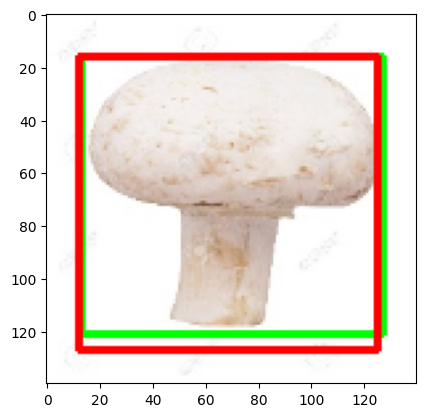

In [26]:
# Inference using best saved model i.e. best_model.pt
idx = 1

model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validationset[idx] # image tensor has shape of (channel, height, width)
  image = image.unsqueeze(0).to(DEVICE) # Unsqueeze to introduce the batch dimension at 0-th axis so that image tensor's shape becomes (batch_size, channel, height, width)
  out_bbox = model(image)

  xmin, ymin, xmax, ymax = gt_bbox
  min = (int(xmin), int(ymin))
  max = (int(xmax), int(ymax))

  out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]
  out_min = (int(out_xmin), int(out_ymin))
  out_max = (int(out_xmax), int(out_ymax))

  out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(), min, max, (0, 255, 0), 2) # Green bounding box for the ground truth
  out_img = cv2.rectangle(out_img, out_min, out_max, (255, 0, 0), 2) # Red bounding box for the predicted output
  plt.imshow(out_img)

<ipython-input-27-a4f2721179f2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


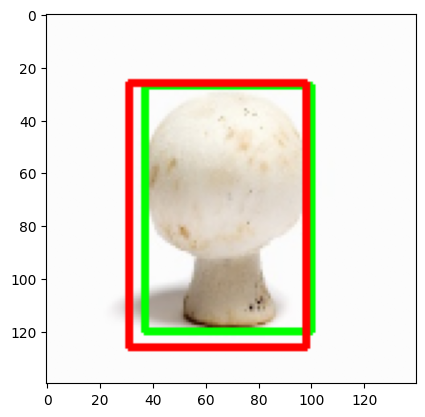

In [27]:
idx = 34

model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validationset[idx] # image tensor has shape of (channel, height, width)
  image = image.unsqueeze(0).to(DEVICE) # Unsqueeze to introduce the batch dimension at 0-th axis so that image tensor's shape becomes (batch_size, channel, height, width)
  out_bbox = model(image)

  xmin, ymin, xmax, ymax = gt_bbox
  min = (int(xmin), int(ymin))
  max = (int(xmax), int(ymax))

  out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]
  out_min = (int(out_xmin), int(out_ymin))
  out_max = (int(out_xmax), int(out_ymax))

  out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(), min, max, (0, 255, 0), 2) # Green bounding box for the ground truth
  out_img = cv2.rectangle(out_img, out_min, out_max, (255, 0, 0), 2) # Red bounding box for the predicted output
  plt.imshow(out_img)